In [3]:
class Image:
    
    def __init__(self, filedir, filename):
        import os 
        
        self.filename = filename
        self.filedir = filedir
        
        #check existance
        self.filepath = os.path.join(filedir, filename)
        #print(self.filepath)
        if not os.path.isfile(self.filepath):
            print('*WARNING** : FILE DOES NOT EXISTS')
        
    def hdu(self, show):
        from astropy.io import fits
        self.fits_hdu = fits.open(self.filepath)
        if (show == 1) :
            self.fits_hdu.info()
        return self.fits_hdu
        
    
    def header(self):
        from astropy.io import fits
        
        self.table = Image.hdu(self,0)
        self.header = self.table[0].header
        return self.header
    
    def show_header_fields(self):
        import numpy as np
        self.header_fields = np.unique(self.header)
        
        return self.header_fields
    
    def get_info(self, info):
        return self.header[info]
    
    
    
    def platesolve(self, force_platesolve, *args):
        from astroquery.astrometry_net import AstrometryNet
        ast = AstrometryNet()
        ast.api_key = 'XXXXXXXX'
            
        timeout=1200
        #check if RA and DEC data present
        check_RA  = 'RA' in self.header
        check_DEC = 'DEC' in self.header
            
        if (force_platesolve ==1):
            
            #SOLVING CODE
            print('------>Forced Platesolving')
            print('------>Solving image via Astrometry.Net\n\
            *WARNING*: this may take some time: timeout is %ds' %timeout)
            
            self.wcs_header = ast.solve_from_image(self.filepath, force_image_upload=True, solve_timeout = timeout)
            return self.wcs_header
        
        else:
            return self.header

        
    def skyfield_box_coord(self, wcs_header):
        #returns de region box of the field image
        
        import numpy as np
        from astropy.wcs import WCS
        import warnings
        from astropy.utils.exceptions import AstropyWarning
        warnings.simplefilter('ignore', category=AstropyWarning)
        import astropy.units as u

        self.wcs_header = wcs_header 
        
        #get number of pixel per axis
        self.nx = np.int32(Image.get_info(self, 'NAXIS1'))
        self.ny = np.int32(Image.get_info(self, 'NAXIS2'))


       
        self.wcs = WCS(self.wcs_header)
        print(self.wcs)

        
        sky_field_center = self.wcs.pixel_to_world(np.int32(self.nx/2),  np.int32(self.ny/2), 0 )
        #print(sky_field_center)
        
      
        #getting boxes coord
        
    
        coord_upleft = self.wcs.wcs_pix2world([[0,  0, 0]], 0)
        coord_upright = self.wcs.wcs_pix2world([[self.nx,  0, 0]], 0)
        coord_downleft = self.wcs.wcs_pix2world([[0,  self.ny, 0]], 0)
        coord_downright = self.wcs.wcs_pix2world([[self.nx, self.ny, 0]], 0)
        
        #print(coord_upleft); print(coord_upright); print(coord_downleft); print(coord_downright)
        
        ra_upleft = coord_upleft[0][0];        dec_upleft = coord_upleft[0][1]
        ra_upright = coord_upright[0][0];      dec_upright = coord_upright[0][1]
        ra_downleft = coord_downleft[0][0];    dec_downleft = coord_downleft[0][1]
        ra_downright = coord_downright[0][0];  dec_downright = coord_downright[0][1]
        
        self.ra_min = min(ra_downleft,ra_downright, ra_upleft, ra_upright)
        self.ra_max = max(ra_downleft, ra_downright, ra_upleft, ra_upright)
        self.dec_min = min(dec_downleft,dec_downright, dec_upleft, dec_upright)
        self.dec_max = max(dec_downleft, dec_downright, dec_upleft, dec_upright)
        
        self.sky_field_box = [self.ra_min, self.ra_max, self.dec_min, self.dec_max]
        #print(ra_min); print(ra_max); print(dec_min); print(dec_max)
        
        return self.sky_field_box
#################################################

    def DeepSky_obj(self, obj_type, obj_cat):
        #obj_cat must be a string vector containing all the query cat
        from astroquery.simbad import Simbad
        import astropy.units as u
        import astropy.coordinates as coord
        
        print('\nRetrieving deep sky object from Simbad')
        self.obj_type = obj_type; self.obj_cat = obj_cat

        criteria = 'ra<=' + str(self.ra_max) +'& ra>=' + str(self.ra_min) \
                 + '& dec<='+ str(self.dec_max)+'& dec>='+ str(self.dec_min)
        print('Criteria:\n%s' %criteria)
        
               

        print('Obj_type = %s' %self.obj_type)
        print('Catalogue:%s \n' %self.obj_cat)
        #self.sources = Simbad.query_criteria(criteria+ '& otype =' + "'"+cat + "'")
        self.sources = Simbad.query_criteria(criteria, otype = self.obj_type, cat = self.obj_cat)

        
        print('-----> Found %d sources' %len(self.sources))
        error = 0
        
        return [self.sources, error]
#################################################
    
    def DeepSky_obj_pixel_loc(self):
        import numpy as np
        from astropy.wcs import WCS
        import warnings
        from astropy.utils.exceptions import AstropyWarning
        warnings.simplefilter('ignore', category=AstropyWarning)
        from astropy.coordinates import SkyCoord
        import astropy.units as u

        print('matching sources to pixel')
        self.source_px = [[],[]]
        for i in range(len(self.sources)):
            print('-----> matching source %d / %d' %(i+1, len(self.sources)), end='\r')
            ra  = self.sources['RA'][i]
            dec = self.sources['DEC'][i]
            c = SkyCoord.from_name(self.sources['MAIN_ID'][i])  
            #print(c)


            #coord = self.wcs.all_world2pix([c, 0], 0)
            coord = self.wcs.wcs_world2pix(c.ra,  c.dec, 0, 0)
            #print(coord[0])
            #print(coord[1])
            self.source_px[0].append(coord[0])
            self.source_px[1].append(coord[1])
        print('\n')
        
        return



            
            
#################################################    
    def annotate_image(self, fignum, savefig):
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.colors import LogNorm
        %matplotlib inline
        from astropy import coordinates, units as u
    
        import scipy.ndimage as ndimage
    
        print('\n.... Retrieving Image RGB Channels ...')


      
        R = self.fits_hdu[0].data[0]; 
        G = self.fits_hdu[0].data[1]; 
        B = self.fits_hdu[0].data[2]; 
        RGBChannels = np.transpose([R, G, B])

        img = RGBChannels
        img = ndimage.rotate(img, 90, reshape=True)
        img = np.flipud(img)
        
        print('-----> RGB Channels acquired\n')

        fig = plt.figure(fignum,figsize=(20, 10))
        ax=plt.subplot(projection=self.wcs, slices=('x', 'y',1000 ))
     

    
        
        plt.imshow(img, norm=LogNorm())
        plt.title(self.filename)
        plt.grid(color='white', linewidth=0.1)
        
        #tbl_crds = coordinates.SkyCoord(self.sources['RA'], self.sources['DEC'], unit=(u.hour, u.deg), frame='icrs')


        # overplot the data in the image
        x = self.source_px[0]
        y = self.source_px[1]
        ax.plot(x, y,'o', mec='w', mfc='none', markersize =3, markeredgewidth=0.2)
        
        plt.gca().invert_yaxis()
        plt.xlabel('RA [hms]'); plt.ylabel('DEC [deg]')
        
        #IMAGE ANNOTATION 
        print('\n... Annotating image ....')
        for i in range(len(x)):
            print('annotating',i, 'out of', len(x), end='\r')
            plt.annotate(self.sources['MAIN_ID'][i], (x[i]+10, y[i] - 10), color='w')
        
        if (savefig ==1):
            
            fig.savefig(image_filename +'_obj_cat='+ str(self.obj_cat) + '_obj_type='+str(self.obj_type)+ '.png', dpi=500)
            print('\n----->Fig Saved...\n')
            
        return


        
        
        
    
#=================================================================


In [28]:
#MAIN


#!ls
import os
import numpy as np
#fits file definition
image_filetype = '.fits'
image_filename = 'rosette'
image_filename = 'M81&M82'
image_filename = 'leo_triplet'
#image_filename = 'markarian'
#image_filename = 'ic1396'
#image_filename = 'bubble_nebula'




#image_filename = 'm101'



image_filename += image_filetype

print('\nUsing %s\n' %image_filename)
    
work_dir = os.getcwd()
file_dir = work_dir

myimage = Image(file_dir, image_filename)
#myimage.hdu(show=0)

myimage_header = myimage.header()
myimage_fields = myimage.show_header_fields()
#myimage_fields

myimage_header
#myimage_info = myimage.astro_info()



myimage_wcs_header = myimage.platesolve(force_platesolve = 0)


myimage.skyfield_box_coord(wcs_header = myimage_wcs_header)
#myimage.image_plot(fignum=1, savefig=0)

# https://simbad.cds.unistra.fr/guide/otypes.htx
[sources, error] = myimage.DeepSky_obj(obj_type = 'G', obj_cat=None) 

if not error:
    myimage.DeepSky_obj_pixel_loc()
    myimage.annotate_image(fignum=1, savefig=0)
    sources




Using leo_triplet.fits

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  ''  
CRVAL : 169.954752516  13.28115775272  0.0  
CRPIX : 2476.0  1610.5  0.0  
CD1_1 CD1_2 CD1_3  : -0.0003437712818454  4.065759723364e-06  0.0  
CD2_1 CD2_2 CD2_3  : -4.161058874373e-06  -0.0003438977166936  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1.0  
NAXIS : 4951  3220  3

Retrieving deep sky object from Simbad
Criteria:
ra<=170.8336584244866& ra>=169.0715537088742& dec<=13.843408859823366& dec>=12.715621357199787
Obj_type = G
Catalogue:None 

-----> Found 189 sources
matching sources to pixel
-----> matching source 189 / 189


.... Retrieving Image RGB Channels ...


KeyboardInterrupt: 

In [43]:
Simbad.list_votable_fields()


--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [48]:
(myimage_header['CROTA1']+myimage_header['CROTA2'])/2


179.31458229115

In [42]:
import pandas as pd
script = '(region(box, GAL, 0 +0, 0.5d 0.5d) | region(box, GAL, 43.3 -0.2, 0.25d 0.25d))'
result = Simbad.query_object('M66')
result = result.to_pandas()
result

,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
0,M 66,11 20 15.026,+12 59 28.64,7,7,NaN,NaN,0,C,I,2006AJ....131.1163S,1


In [25]:

from astroquery.simbad import Simbad
source = Simbad.query_criteria(cat = 'M51')
source

/usr/local/Cellar/jupyterlab/3.2.9/libexec/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'cat=M51': Command error : No object found
  warnings.warn("Warning: The script line number %i raised "


In [29]:
help(Simbad)

Help on SimbadClass in module astroquery.simbad.core object:

class SimbadClass(SimbadBaseQuery)
 |  The class for querying the Simbad web service.
 |  
 |  Note that SIMBAD suggests submitting no more than 6 queries per second; if
 |  you submit more than that, your IP may be temporarily blacklisted
 |  (http://simbad.u-strasbg.fr/simbad/sim-help?Page=sim-url)
 |  
 |  Method resolution order:
 |      SimbadClass
 |      SimbadBaseQuery
 |      astroquery.query.BaseQuery
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_votable_fields(self, *args)
 |      Sets fields to be fetched in the VOTable. Must be one of those listed
 |      by `list_votable_fields`.
 |      
 |      Parameters
 |      ----------
 |      list of field_names
 |  
 |  get_field_description(self, field_name)
 |      Displays a description of the VOTable field.
 |      
 |      Parameters
 |      -------

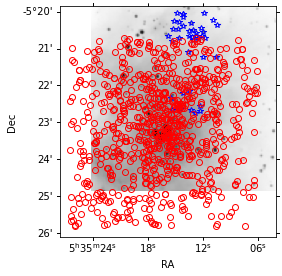

In [20]:
from astropy import coordinates, units as u, wcs
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
import pylab as pl

center = coordinates.SkyCoord.from_name('Orion KL')

# Grab an image from SkyView of the Orion KL nebula region
imglist = SkyView.get_images(position=center, survey='2MASS-J')

# the returned value is a list of images, but there is only one
img = imglist[0]

# 'img' is now a fits.HDUList object; the 0th entry is the image
mywcs = wcs.WCS(img[0].header)

fig = pl.figure(1)
fig.clf() # just in case one was open before
# use astropy's wcsaxes tool to create an RA/Dec image
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(img[0].data, cmap='gray_r', interpolation='none', origin='lower',
          norm=pl.matplotlib.colors.LogNorm())


# retrieve a specific table from Vizier to overplot
tablelist = Vizier.query_region(center, radius=5*u.arcmin,
                                catalog='J/ApJ/826/16/table1')
# again, the result is a list of tables, so we'll get the first one
result = tablelist[0]

# convert the ra/dec entries in the table to astropy coordinates
tbl_crds = coordinates.SkyCoord(result['RAJ2000'], result['DEJ2000'],
                                unit=(u.hour, u.deg), frame='fk5')

# we want this table too:
tablelist2 = Vizier(row_limit=10000).query_region(center, radius=5*u.arcmin,
                                                  catalog='J/ApJ/540/236')
result2 = tablelist2[0]
tbl_crds2 = coordinates.SkyCoord(result2['RAJ2000'], result2['DEJ2000'],
                                 unit=(u.hour, u.deg), frame='fk5')


# overplot the data in the image
ax.plot(tbl_crds.ra, tbl_crds.dec, '*', transform=ax.get_transform('fk5'),
        mec='b', mfc='none')
ax.plot(tbl_crds2.ra, tbl_crds2.dec, 'o', transform=ax.get_transform('fk5'),
        mec='r', mfc='none')
# zoom in on the relevant region
#ax.axis([100, 200, 100, 200])